In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load your JSON test results
with open("results/test_results_20250610_214117.json", "r") as f:
    data = json.load(f)

# Extract the test results
tests = data["tests"]
print(f"Loaded {len(tests)} tests.")


Loaded 19200 tests.


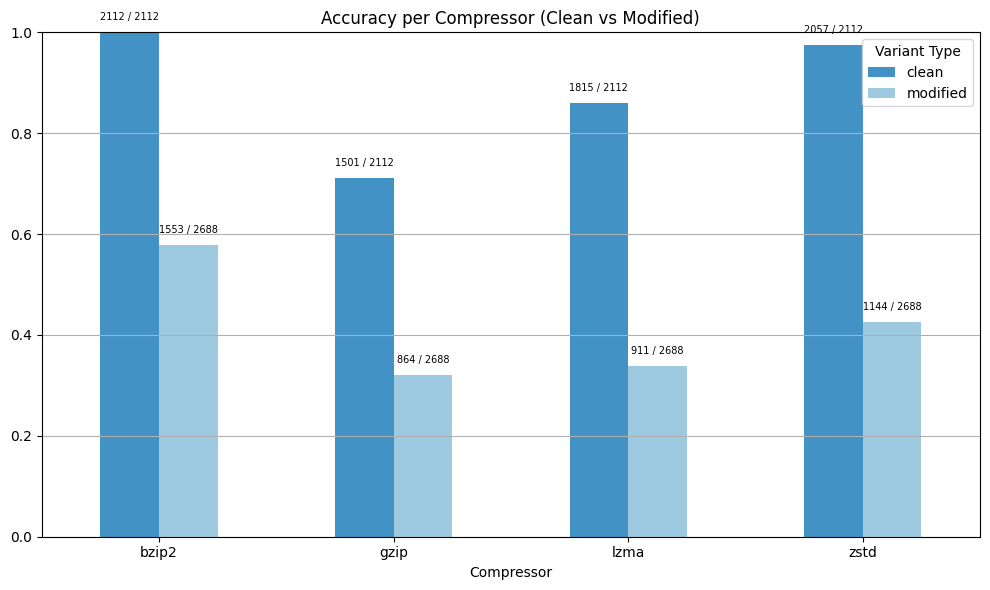

In [27]:
# Create a DataFrame for clean vs modified classification
rows = []
for test in tests:
    compressor = test["compressor"]
    is_clean = test.get("modification_type") == "clean"
    correct = test.get("correct") is True
    rows.append({
        "compressor": compressor,
        "type": "clean" if is_clean else "modified",
        "correct": int(correct)
    })

df_clean_mod = pd.DataFrame(rows)

# Summarize
summary = df_clean_mod.groupby(["compressor", "type"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="compressor", columns="type", values="accuracy").fillna(0)
correct_counts = summary.pivot(index="compressor", columns="type", values="sum").fillna(0).astype(int)
total_counts = summary.pivot(index="compressor", columns="type", values="count").fillna(0).astype(int)

# Plot
ax = pivot.plot(kind="bar", figsize=(10, 6), title="Accuracy per Compressor (Clean vs Modified)", color=["#4292C6", "#9ECAE1"] )
plt.xlabel("Compressor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Variant Type", loc="upper right")
plt.tight_layout()
plt.grid(axis="y")

# Add count labels: correct / total
for bars, label_type in zip(ax.containers, pivot.columns):
    for bar, compressor in zip(bars, pivot.index):
        correct = correct_counts.loc[compressor, label_type]
        total = total_counts.loc[compressor, label_type]
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{correct} / {total}",
            ha='center',
            va='bottom',
            fontsize=7
        )

plt.show()


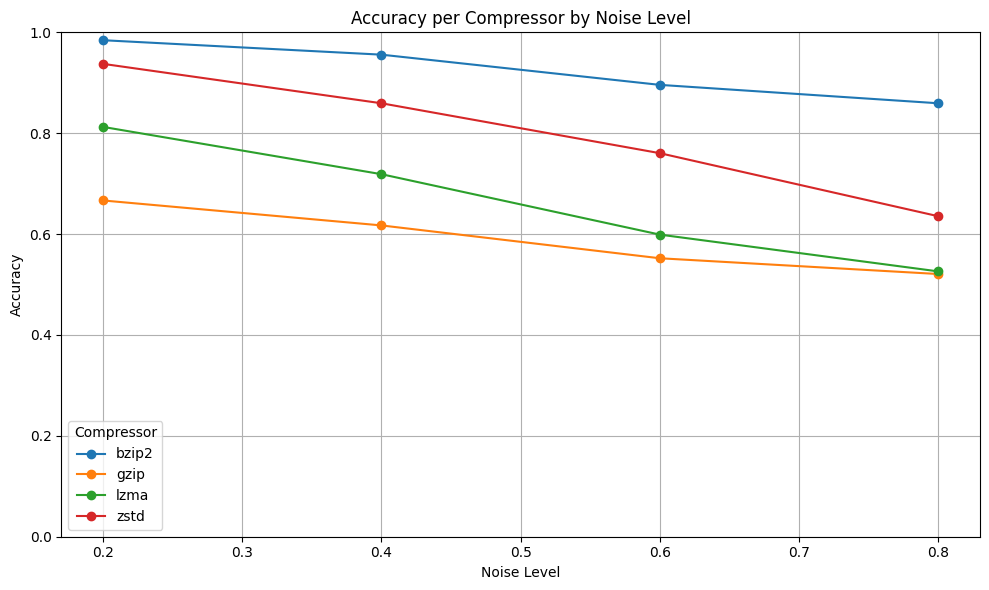

In [6]:
# First pass: detect noise levels dynamically
noise_levels_found = set()
for test in tests:
    if test.get("modification_type") != "noise":
        continue

    variant = test.get("variant", "")
    filename = test.get("file", "")
    
    match = re.search(r"noise[_\-]?(?:white|pink)?[_\-]?([0-9.]+)", variant) or \
            re.search(r"noise[_\-]?(?:white|pink)?[_\-]?([0-9.]+)", filename)

    if match:
        try:
            level = float(match.group(1))
            noise_levels_found.add(level)
        except ValueError:
            continue

# Second pass: build DataFrame
rows = []
for test in tests:
    if test.get("modification_type") != "noise":
        continue

    variant = test.get("variant", "")
    filename = test.get("file", "")
    
    match = re.search(r"noise[_\-]?(?:white|pink)?[_\-]?([0-9.]+)", variant) or \
            re.search(r"noise[_\-]?(?:white|pink)?[_\-]?([0-9.]+)", filename)

    if match:
        try:
            level = float(match.group(1))
        except ValueError:
            continue

        if level in noise_levels_found:
            rows.append({
                "compressor": test["compressor"],
                "noise_level": level,
                "correct": int(test.get("correct") is True)
            })

df_noise = pd.DataFrame(rows)

# Group and calculate accuracy
summary = df_noise.groupby(["compressor", "noise_level"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="noise_level", columns="compressor", values="accuracy").sort_index()

# Plot
plt.figure(figsize=(10, 6))
for compressor in pivot.columns:
    plt.plot(pivot.index, pivot[compressor], marker='o', label=compressor)

plt.title("Accuracy per Compressor by Noise Level")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Compressor")
plt.tight_layout()
plt.show()


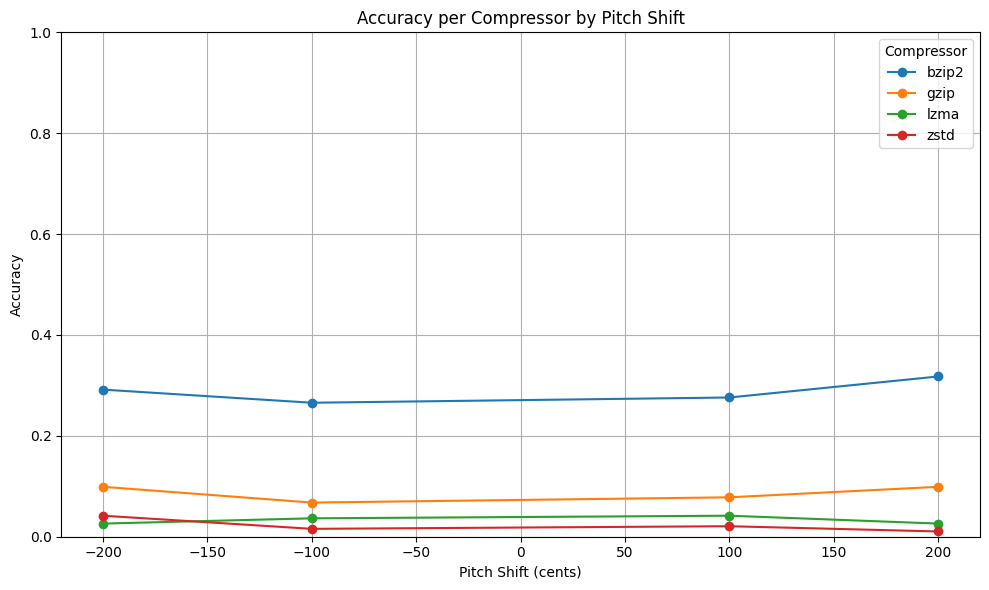

In [7]:
# First pass: collect all valid pitch values
pitch_levels_found = set()
for test in tests:
    if test.get("modification_type") == "pitch":
        value = test.get("modification_value")
        if isinstance(value, (int, float)):
            pitch_levels_found.add(float(value))

# Second pass: extract rows for those pitch levels
rows = []
for test in tests:
    if test.get("modification_type") != "pitch":
        continue

    value = test.get("modification_value")
    if not isinstance(value, (int, float)):
        continue

    compressor = test.get("compressor")
    correct = test.get("correct") is True
    pitch = float(value)

    if pitch in pitch_levels_found:
        rows.append({
            "compressor": compressor,
            "pitch": pitch,
            "correct": int(correct)
        })

df_pitch = pd.DataFrame(rows)

# Group and summarize accuracy
summary = df_pitch.groupby(["compressor", "pitch"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="pitch", columns="compressor", values="accuracy").sort_index()

# Plot
plt.figure(figsize=(10, 6))
for compressor in pivot.columns:
    plt.plot(pivot.index, pivot[compressor], marker='o', label=compressor)

plt.title("Accuracy per Compressor by Pitch Shift")
plt.xlabel("Pitch Shift (cents)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Compressor")
plt.tight_layout()
plt.show()


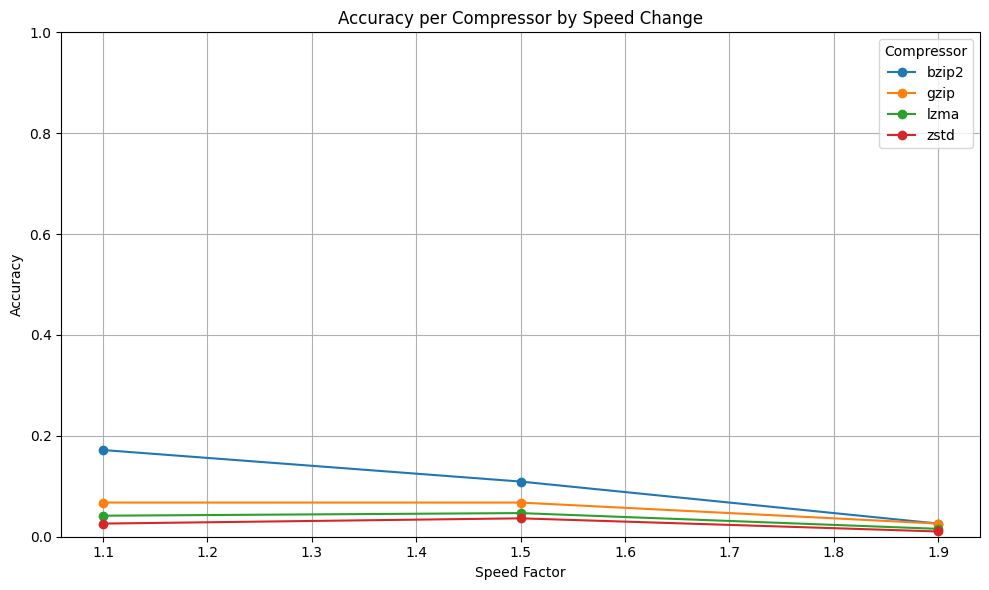

In [8]:
# First pass: collect all valid speed values
speed_levels_found = set()
for test in tests:
    if test.get("modification_type") == "speed":
        value = test.get("modification_value")
        if isinstance(value, (int, float)):
            speed_levels_found.add(float(value))

# Second pass: extract rows for valid speed values
rows = []
for test in tests:
    if test.get("modification_type") != "speed":
        continue

    value = test.get("modification_value")
    if not isinstance(value, (int, float)):
        continue

    compressor = test.get("compressor")
    correct = test.get("correct") is True
    speed = float(value)

    if speed in speed_levels_found:
        rows.append({
            "compressor": compressor,
            "speed": speed,
            "correct": int(correct)
        })

df_speed = pd.DataFrame(rows)

# Group and summarize accuracy
summary = df_speed.groupby(["compressor", "speed"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="speed", columns="compressor", values="accuracy").sort_index()

# Plot
plt.figure(figsize=(10, 6))
for compressor in pivot.columns:
    plt.plot(pivot.index, pivot[compressor], marker='o', label=compressor)

plt.title("Accuracy per Compressor by Speed Change")
plt.xlabel("Speed Factor")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Compressor")
plt.tight_layout()
plt.show()


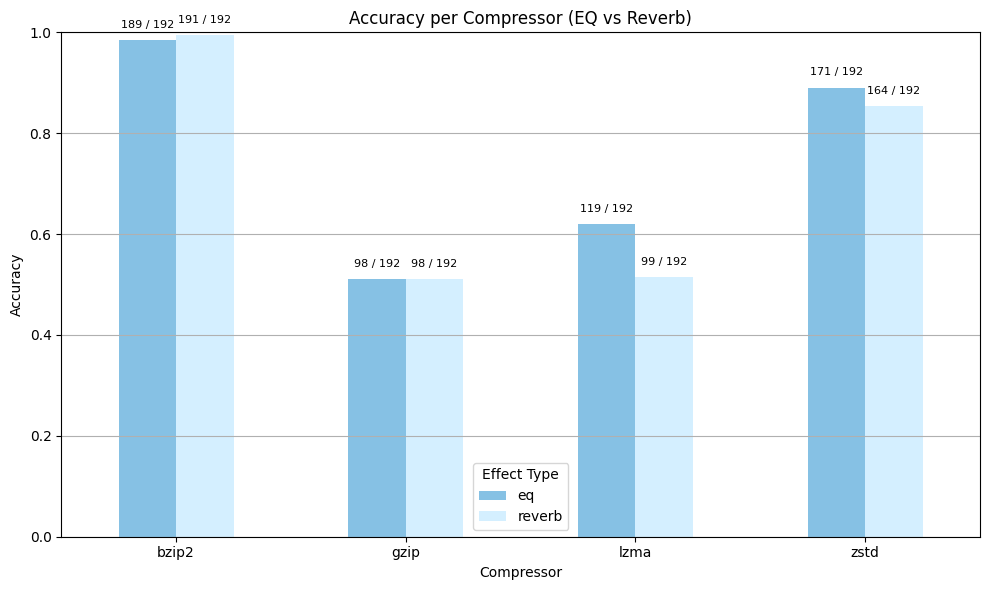

In [14]:
# Filter relevant tests
rows = []
for test in tests:
    mod_type = test.get("modification_type")
    if mod_type not in ["eq", "reverb"]:
        continue

    compressor = test.get("compressor")
    correct = test.get("correct") is True

    rows.append({
        "compressor": compressor,
        "type": mod_type,
        "correct": int(correct)
    })

df_effects = pd.DataFrame(rows)

# Group and summarize
summary = df_effects.groupby(["compressor", "type"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="compressor", columns="type", values="accuracy").fillna(0)
counts = summary.pivot(index="compressor", columns="type", values="count").fillna(0).astype(int)
corrects = summary.pivot(index="compressor", columns="type", values="sum").fillna(0).astype(int)

# Plot
ax = pivot.plot(kind="bar", figsize=(10, 6), title="Accuracy per Compressor (EQ vs Reverb)", color=["#86C1E4", "#D4EFFF"])
plt.ylabel("Accuracy")
plt.xlabel("Compressor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis="y")
plt.legend(title="Effect Type")

# Add count labels
for bars, effect_type in zip(ax.containers, pivot.columns):
    for bar, compressor in zip(bars, pivot.index):
        total = counts.loc[compressor, effect_type]
        correct = corrects.loc[compressor, effect_type]
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{correct} / {total}",
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()


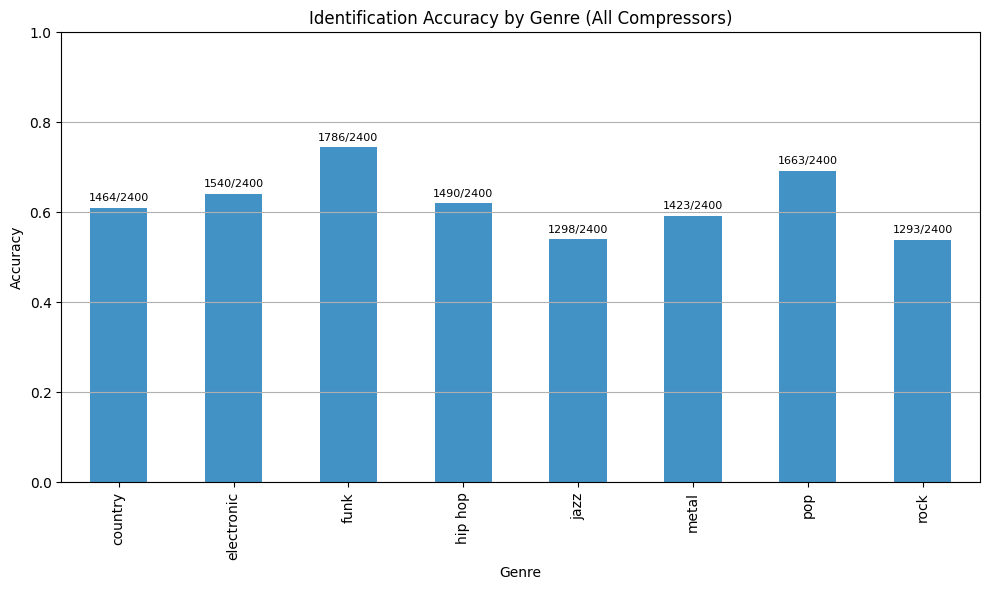

In [26]:
# === PARAMETERS ===
selected_compressor = None  # Set to 'gzip', 'bzip2', etc. or None to include all

# Optional compressor filtering
filtered_tests = [
    t for t in tests
    if selected_compressor is None or t["compressor"] == selected_compressor
]

# Collect accuracy by genre (USE filtered_tests HERE)
rows = []
for test in filtered_tests:
    genre = test.get("genre")
    correct = test.get("correct") is True
    if genre:
        rows.append({
            "genre": genre,
            "correct": int(correct)
        })

df_genre = pd.DataFrame(rows)

# Group and summarize
summary = df_genre.groupby("genre")["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Plot
ax = summary.plot(
    x="genre",
    y="accuracy",
    kind="bar",
    legend=False,
    figsize=(10, 6),
    title=f"Identification Accuracy by Genre ({selected_compressor or 'All Compressors'})",
    color="#4292C6"
)

# Add count labels
for i, row in summary.iterrows():
    ax.text(i, row["accuracy"] + 0.01, f'{int(row["sum"])}/{int(row["count"])}',
            ha='center', va='bottom', fontsize=8)

plt.ylabel("Accuracy")
plt.xlabel("Genre")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


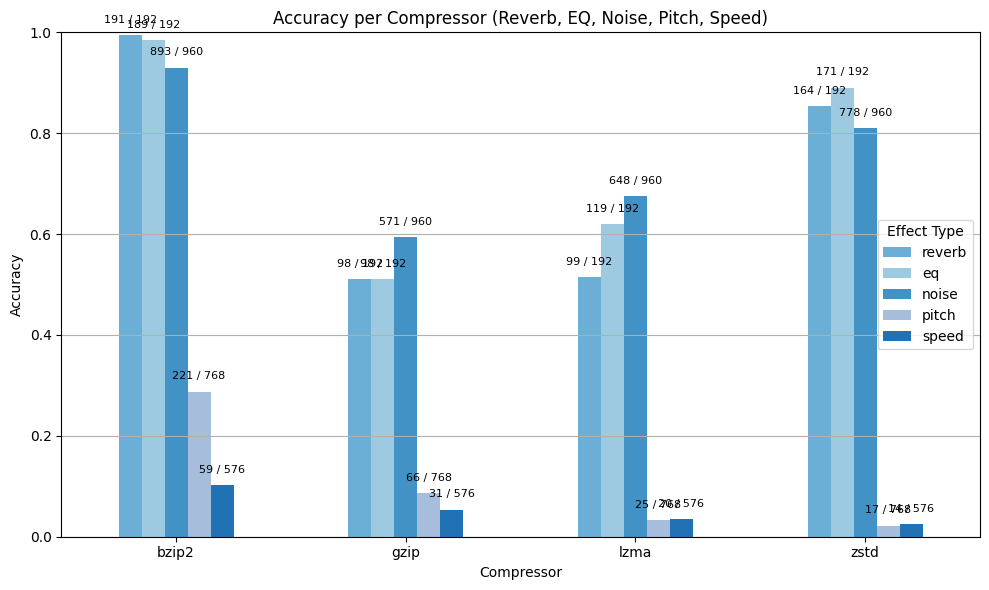

In [23]:
# Filter relevant tests
rows = []
for test in tests:
    mod_type = test.get("modification_type")
    if mod_type not in ["eq", "reverb", "pitch", "speed", "noise"]:
        continue

    compressor = test.get("compressor")
    correct = test.get("correct") is True

    rows.append({
        "compressor": compressor,
        "type": mod_type,
        "correct": int(correct)
    })

df_effects = pd.DataFrame(rows)

# Group and summarize
summary = df_effects.groupby(["compressor", "type"])["correct"].agg(["sum", "count"]).reset_index()
summary["accuracy"] = summary["sum"] / summary["count"]

# Pivot for plotting
pivot = summary.pivot(index="compressor", columns="type", values="accuracy").fillna(0)
counts = summary.pivot(index="compressor", columns="type", values="count").fillna(0).astype(int)
corrects = summary.pivot(index="compressor", columns="type", values="sum").fillna(0).astype(int)

# Reorder effects as requested
effect_order = ["reverb", "eq", "noise", "pitch", "speed"]
pivot = pivot[effect_order]
counts = counts[effect_order]
corrects = corrects[effect_order]

# Plot
colors = ["#6BAED6", "#9ECAE1", "#4292C6", "#A6BDDB", "#2171B5"]
ax = pivot.plot(
    kind="bar",
    figsize=(10, 6),
    title="Accuracy per Compressor (Reverb, EQ, Noise, Pitch, Speed)",
    color=colors
)

plt.ylabel("Accuracy")
plt.xlabel("Compressor")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis="y")
plt.legend(title="Effect Type")

# Add count labels: correct / total
for bars, effect_type in zip(ax.containers, pivot.columns):
    for bar, compressor in zip(bars, pivot.index):
        total = counts.loc[compressor, effect_type]
        correct = corrects.loc[compressor, effect_type]
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{correct} / {total}",
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()